In [1]:
import os
import time
import json
%reload_ext e2emlstorlets.tools.ipython

In [2]:
os.environ['OS_AUTH_VERSION'] = '3'
os.environ['OS_AUTH_URL'] = 'http://127.0.0.1:5000/v3'
os.environ['OS_USERNAME'] = 'tester'
os.environ['OS_PASSWORD'] = 'testing'
os.environ['OS_USER_DOMAIN_NAME'] = 'default'
os.environ['OS_PROJECT_DOMAIN_NAME'] = 'default'
os.environ['OS_PROJECT_NAME'] = 'test'

In [3]:
%%storletapp extract_face.ExtractFace
import cv2
import numpy as np

def detect(im):
    mat=cv2.imdecode(im, cv2.IMREAD_GRAYSCALE)
    cascade = cv2.CascadeClassifier("/usr/local/share/OpenCV/haarcascades/haarcascade_frontalface_alt2.xml")
    rects = cascade.detectMultiScale(mat)

    if len(rects) == 0:
        return [], mat
    rects[:, 2:] += rects[:, :2]
    rect = rects[0]
    return mat, rect

def crop(img, rect):
    h = rect[3]-rect[1]
    w = rect[2]-rect[0]
    x = rect[0]
    y = rect[1]
    hm = int(0.1 * h)
    if y < hm:
        h = h + (hm - y)
        hm = y
    return img[y-hm:y+h, x:x+w]

class ExtractFace(object):
    def __init__(self, logger):
        self.logger = logger

    def __call__(self, in_files, out_files, params):
        metadata = in_files[0].get_metadata()
        out_files[0].set_metadata(metadata)

        # Read the image
        img_str = ''
        while True:
            buf = in_files[0].read(1024)
            if not buf:
                break
            img_str += buf
        img_nparr = np.fromstring(img_str, np.uint8)
        
        # Detect face
        mat, rect = detect(img_nparr)

        # Crop the face and decrease resolution
        face = crop(mat, rect)
        small_face = cv2.resize(face, (50,55))
        
        # Write result
        retval, small_face_buf = cv2.imencode('.jpg', small_face)
        out_files[0].write(small_face_buf)
        
        in_files[0].close()
        out_files[0].close()
        self.logger.debug('Done\n')

Upload storlets succeeded /storlet/extract_face.py
Example command `swift download <container> <object> -H X-Run-Storlet:extract_face.py`


In [6]:
# Iterate over all pictures, and extract faces
start_time = time.time()
%list_container -i train -o obj_list
for obj in obj_list:
    input_path=os.path.join('/train',obj)
    output_path=os.path.join('/extracted',obj)
    %copy \
        --storlet extract_face.py \
        --input path:$input_path \
        --output path:$output_path \
        -o result
extract_faces_time = time.time() - start_time
print('Done extracting faces in %d seconds' % round(extract_faces_time))

Done extracting faces in 15 seconds


In [ ]:
# Show before and after face extraction
%show_image --input path:/train/bibi21.jpeg
%show_image --input path:/extracted/bibi21.jpeg

In [8]:
# Train the model with all faces
start_time = time.time()
input_path = os.path.join('path:extracted/', obj_list[0])
extra = ','.join([ '/extracted/%s' % obj_name for obj_name in obj_list[1:]])
output_path = 'path:/trained/model'
params = {'hidden_layer_sizes': '(100, 20, 8)',
          'alpha': '0.00000004',
          'tol': '1e-9'}
%copy \
    --storlet train_model.py \
    --input $input_path \
    --output $output_path \
    --extra $extra \
    -i params \
    -o result
train_model_time = time.time() - start_time
print('Model training done in %d seconds' % round(train_model_time))

Model training done in 40 seconds


In [ ]:
%play_video -c test -v bibi_mov.avi

In [9]:
# Add face recognition tag
start_time = time.time()
input_path = 'path:/test/trump_mov.avi'
output_path = 'path:/video/tagged_trump_mov.avi'
extra_resources = '/trained/model'
%copy \
    --storlet video_recognize_face.py \
    --input $input_path \
    --output $output_path \
    --extra $extra_resources \
    -o result
recognize_faces_time = time.time() - start_time
print('Recognize face done in %d seconds' % round(recognize_faces_time))

Recognize face done in 41 seconds


In [10]:
%play_video -c video -v tagged_trump_mov.avi

In [4]:
# now lets see how this performs when working against S3
from e2emlstorlets.s3 import extract_faces, \
    train_model, recognize_faces
start_time = time.time()
extract_faces.extract_and_upload_all()
extract_faces_s3_time = time.time() - start_time
print('Done extracting faces in %d seconds' % round(extract_faces_s3_time))

start_time = time.time()
train_model.train_and_upload_model()
train_model_s3_time = time.time() - start_time
print('Model training done in %d seconds' % round(train_model_s3_time))

start_time = time.time()
recognize_faces.get_tag_and_upload("bibi_mov.avi")
tag_faces_s3_time = time.time() - start_time
print('Recognizing faces done in %d seconds' % round(tag_faces_s3_time))

Processing bibi1.jpeg
Uploading small_bibi1.jpeg
Processing bibi10.jpeg
Uploading small_bibi10.jpeg
Processing bibi11.jpeg
Uploading small_bibi11.jpeg
Processing bibi12.jpeg
Uploading small_bibi12.jpeg
Processing bibi13.jpeg
Uploading small_bibi13.jpeg
Processing bibi14.jpeg
Uploading small_bibi14.jpeg
Processing bibi15.jpeg
Uploading small_bibi15.jpeg
Processing bibi16.jpeg
Uploading small_bibi16.jpeg
Processing bibi17.jpeg
Uploading small_bibi17.jpeg
Processing bibi18.jpeg
Uploading small_bibi18.jpeg
Processing bibi19.jpeg
Uploading small_bibi19.jpeg
Processing bibi2.jpeg
Uploading small_bibi2.jpeg
Processing bibi20.jpeg
Uploading small_bibi20.jpeg
Processing bibi21.jpeg
Uploading small_bibi21.jpeg
Processing bibi22.jpeg
Uploading small_bibi22.jpeg
Processing bibi23.jpeg
Uploading small_bibi23.jpeg
Processing bibi24.jpeg
Uploading small_bibi24.jpeg
Processing bibi25.jpeg
Uploading small_bibi25.jpeg
Processing bibi3.jpeg
Uploading small_bibi3.jpeg
Processing bibi4.jpeg
Uploading small

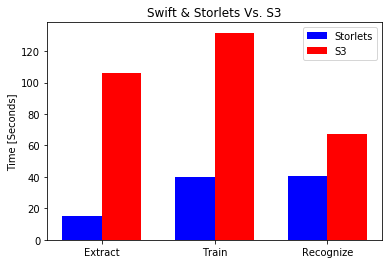

In [11]:
from e2emlstorlets.tools import plot_times
plot_times.show_plot(extract_faces_time,
                     train_model_time,
                     recognize_faces_time,
                     extract_faces_s3_time,
                     train_model_s3_time,
                     tag_faces_s3_time)